# はじめに
このノートブックはナレッジグラフ推論チャレンジ 2024 の応募作品である PDF2NG のシステム使用方法を説明したものです．

# 事前準備

このシステムでは Neo4j の他に OpenAI の API キーを使用します．API キー作成の説明は省略するので，各自で調べて準備しておいてください．[こちらの記事](https://qiita.com/kurata04/items/a10bdc44cc0d1e62dad3)などが参考になると思います．

## Neo4j の準備

このシステムではグラフデータベースである Neo4j を使用します．Neo4j にはブラウザ上で動作する「Neo4j AuraDB」とローカルマシンにダウンロードして使う「Neo4j Desktop」がありますが，今回は「Neo4j AuraDB」の方を使用します．
まずは[こちらのページ](https://neo4j.com/product/auradb/)の「StartFree」もしくは「Get Started Free」ボタンからアカウントを登録してください．

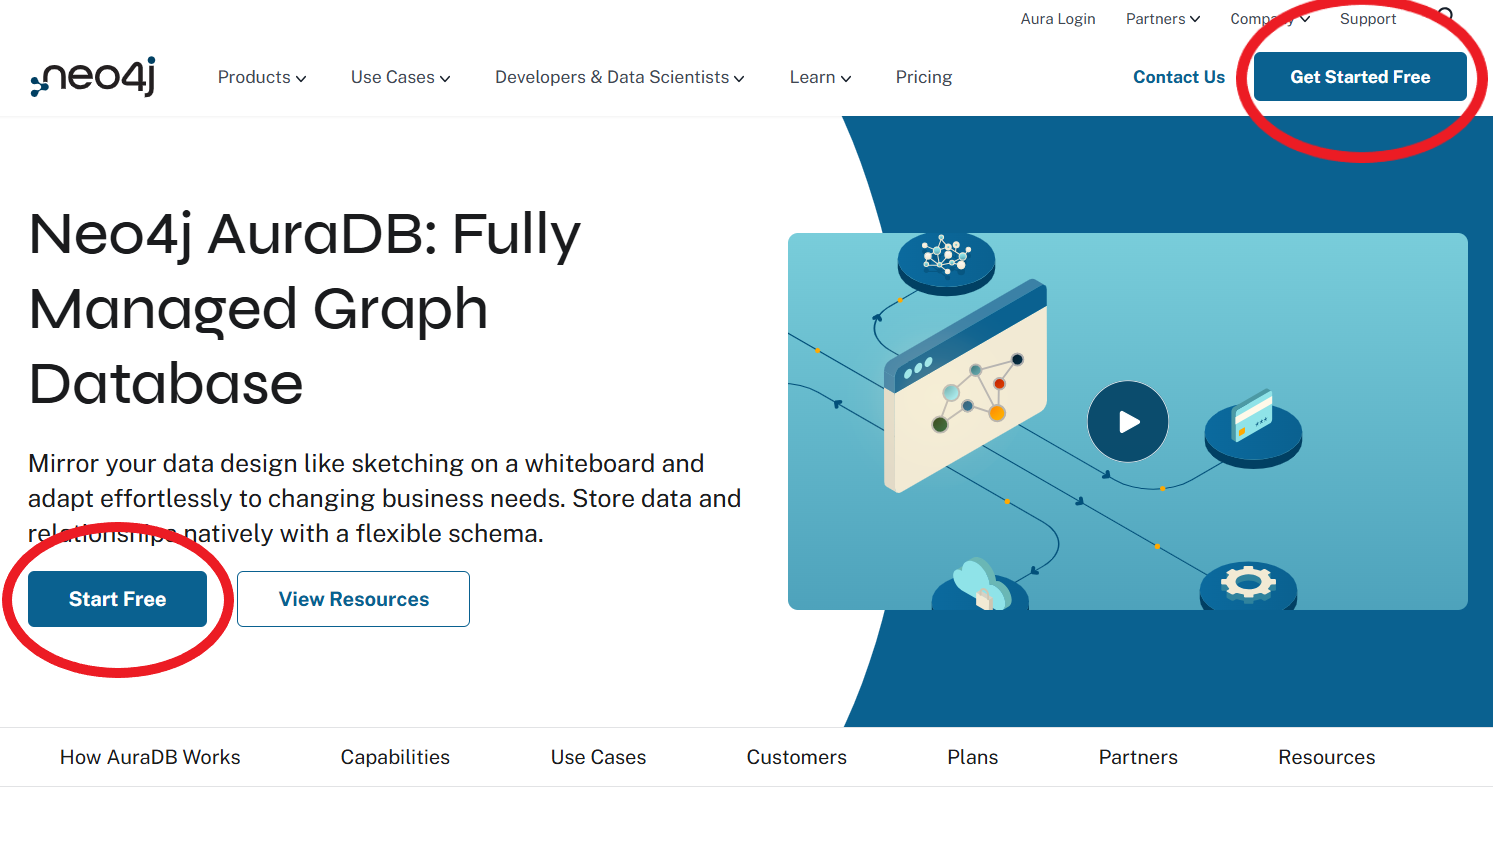

アカウント登録後，ログインすると次のような画面が表示されます．
「Create instance」ボタンをクリックして，データベースのインスタンスを作成します．

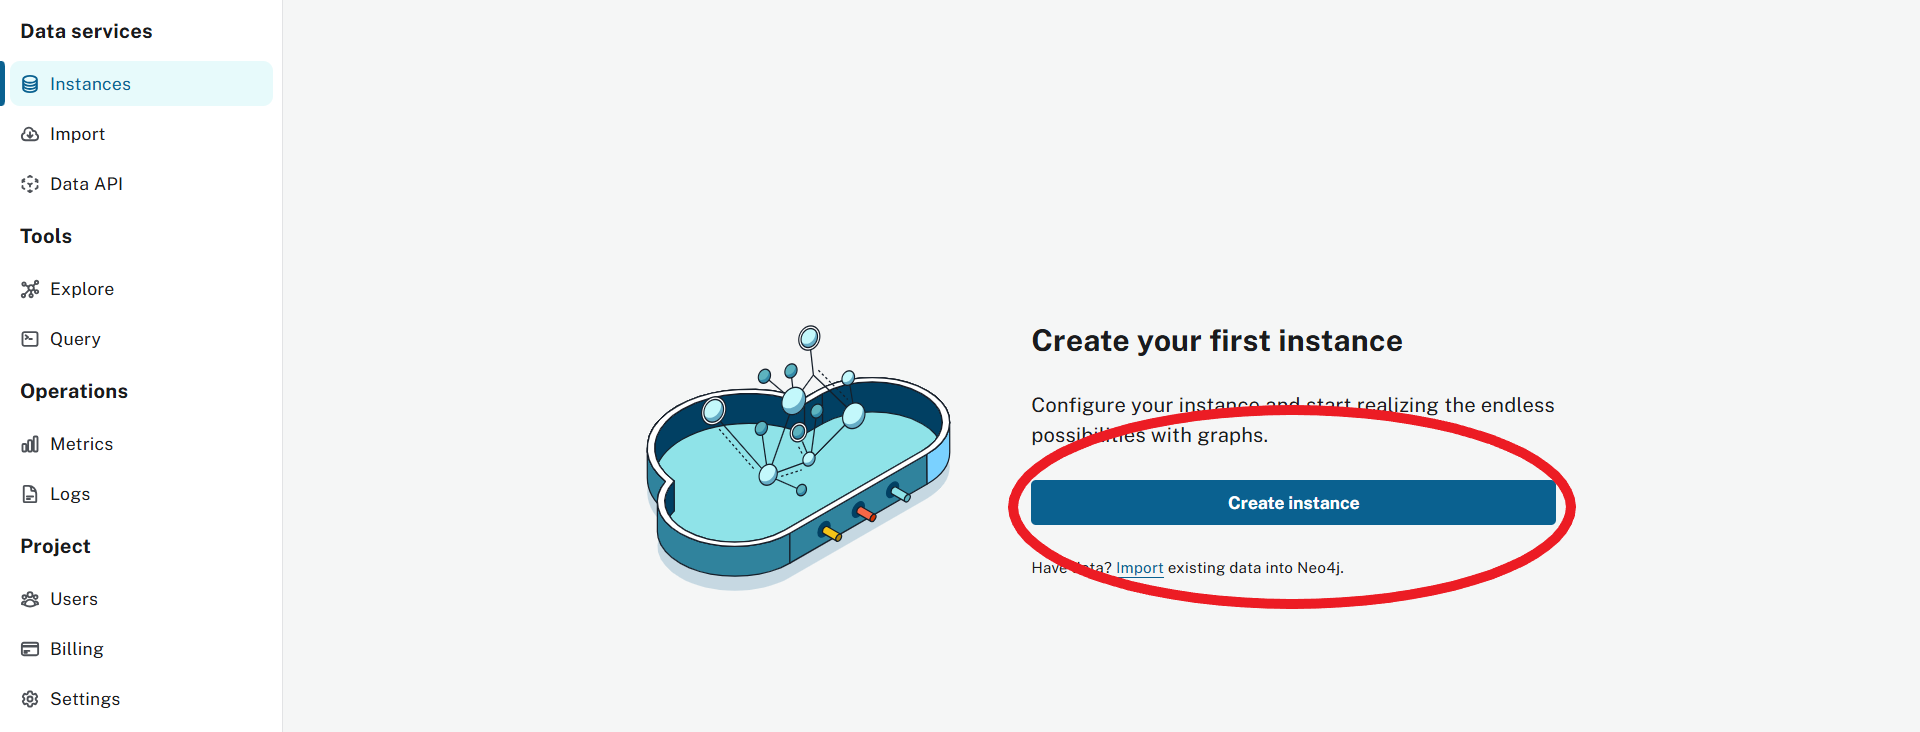

左の AuraDB Free を選択します．

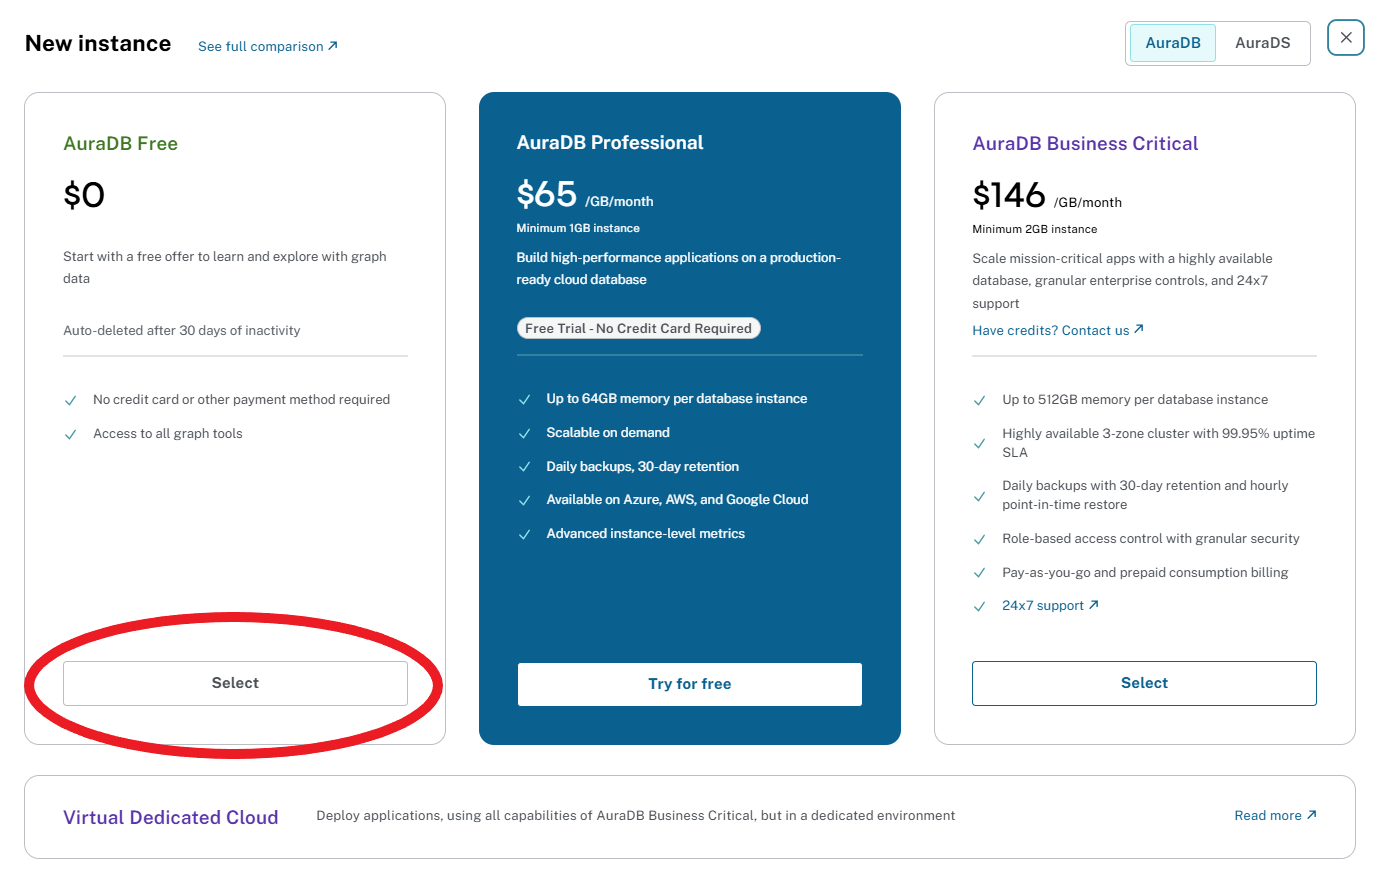

「Download and continue」ボタンをクリックして，テキストファイルをダウンロードします．このテキストファイルの情報は後ほど使います．インスタンスの作成が終わるまでしばらく待ちます．

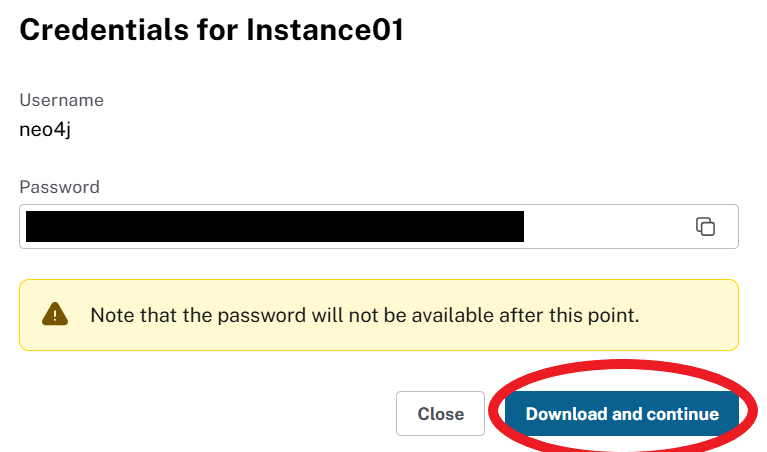

インスタンスの作成が終わったら，右上の「…」ボタンから「Inspect」→「Restore from backup file」の順にクリックします．

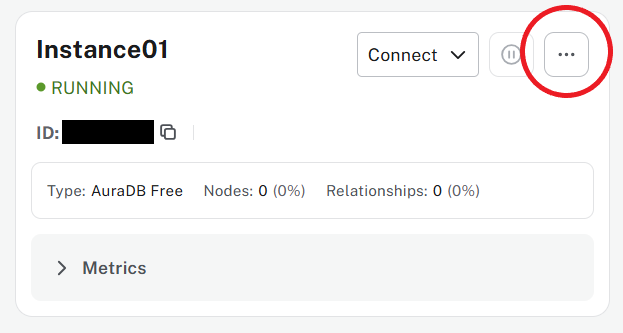

Restore from backup file に github の「default.backup」をドラッグ＆ドロップします．データのロードが始まるのでしばらく待ちます．

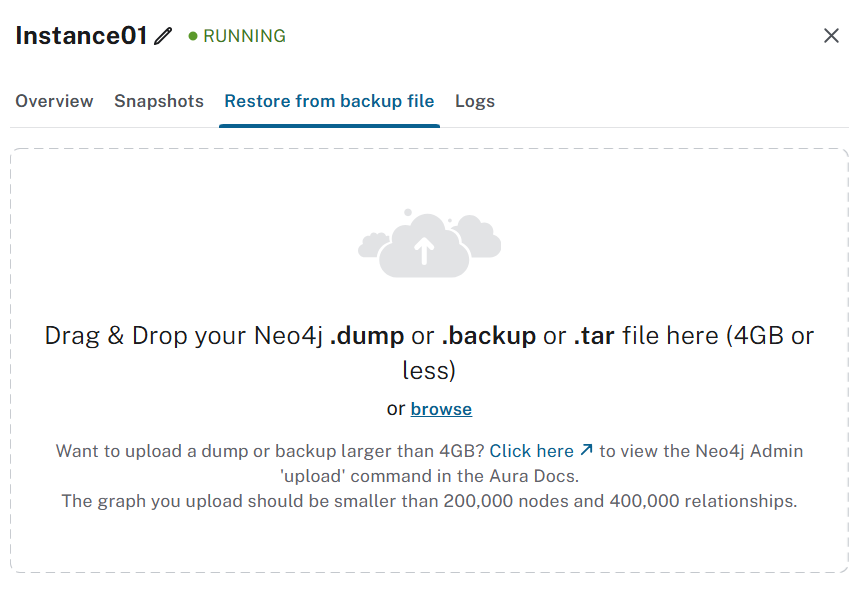

データのロードが終わったら，サイドバーから Query 画面に移動しインスタンスに接続します．

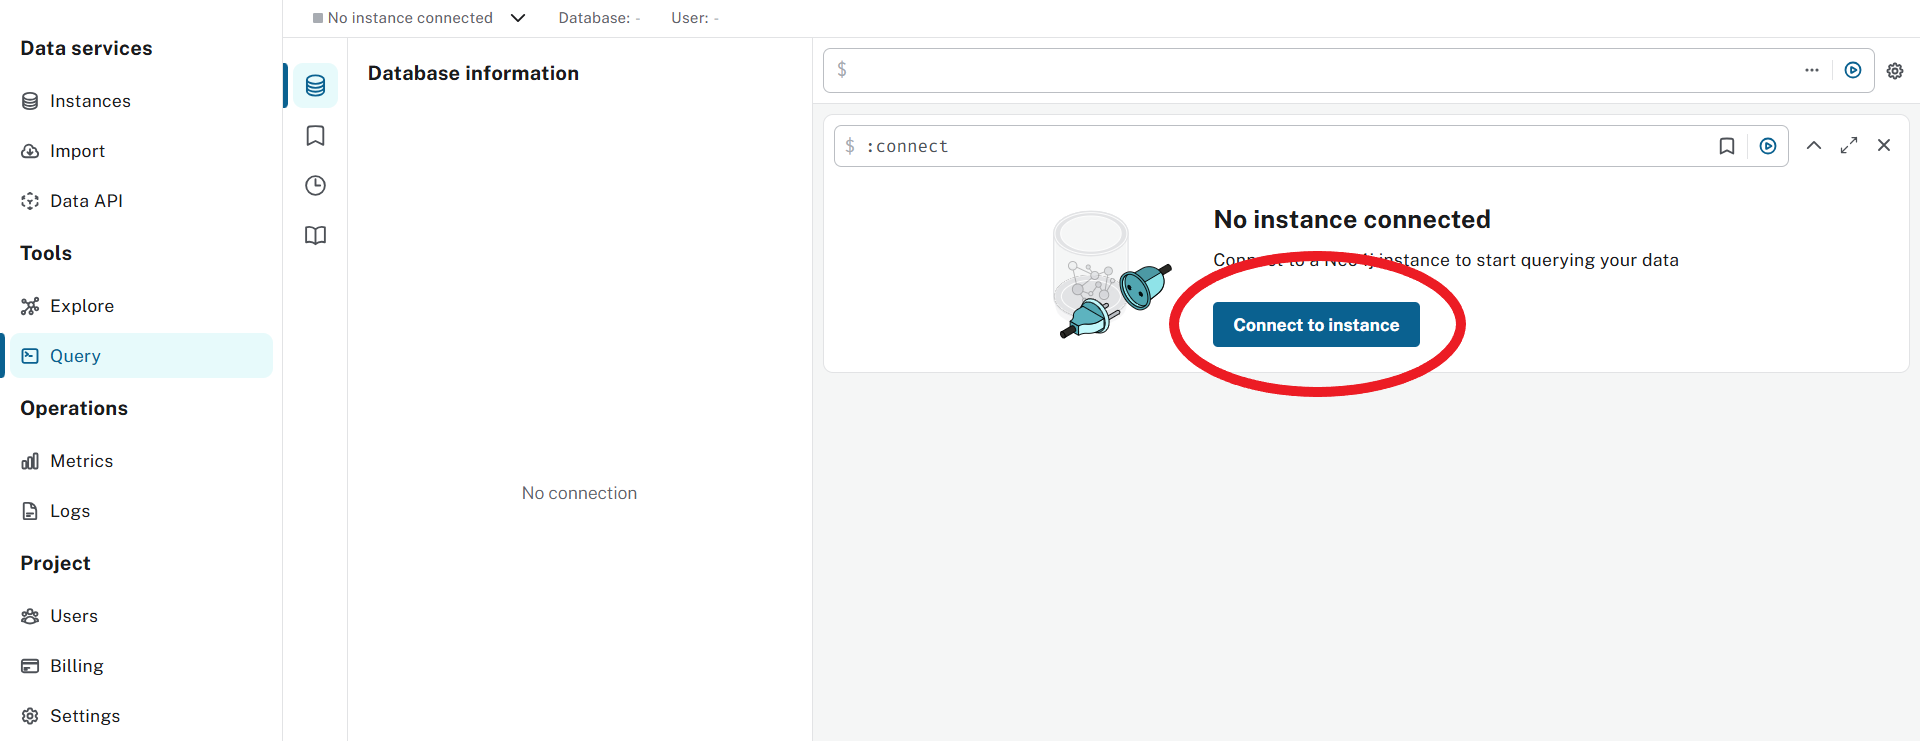

インスタンスに接続後，左の Database information の「*」をクリックし，クエリを実行します．グラフが表示されたら右の Results overview のラベルをクリックし，各ラベルの色と大きさの設定をします．色は各自で自由に設定してください．大きさは 11 段階からラベルの名前に合った大きさを設定してください．すべてのラベルに対して設定が終わったら，Results overview の「↑↓」をクリックします．

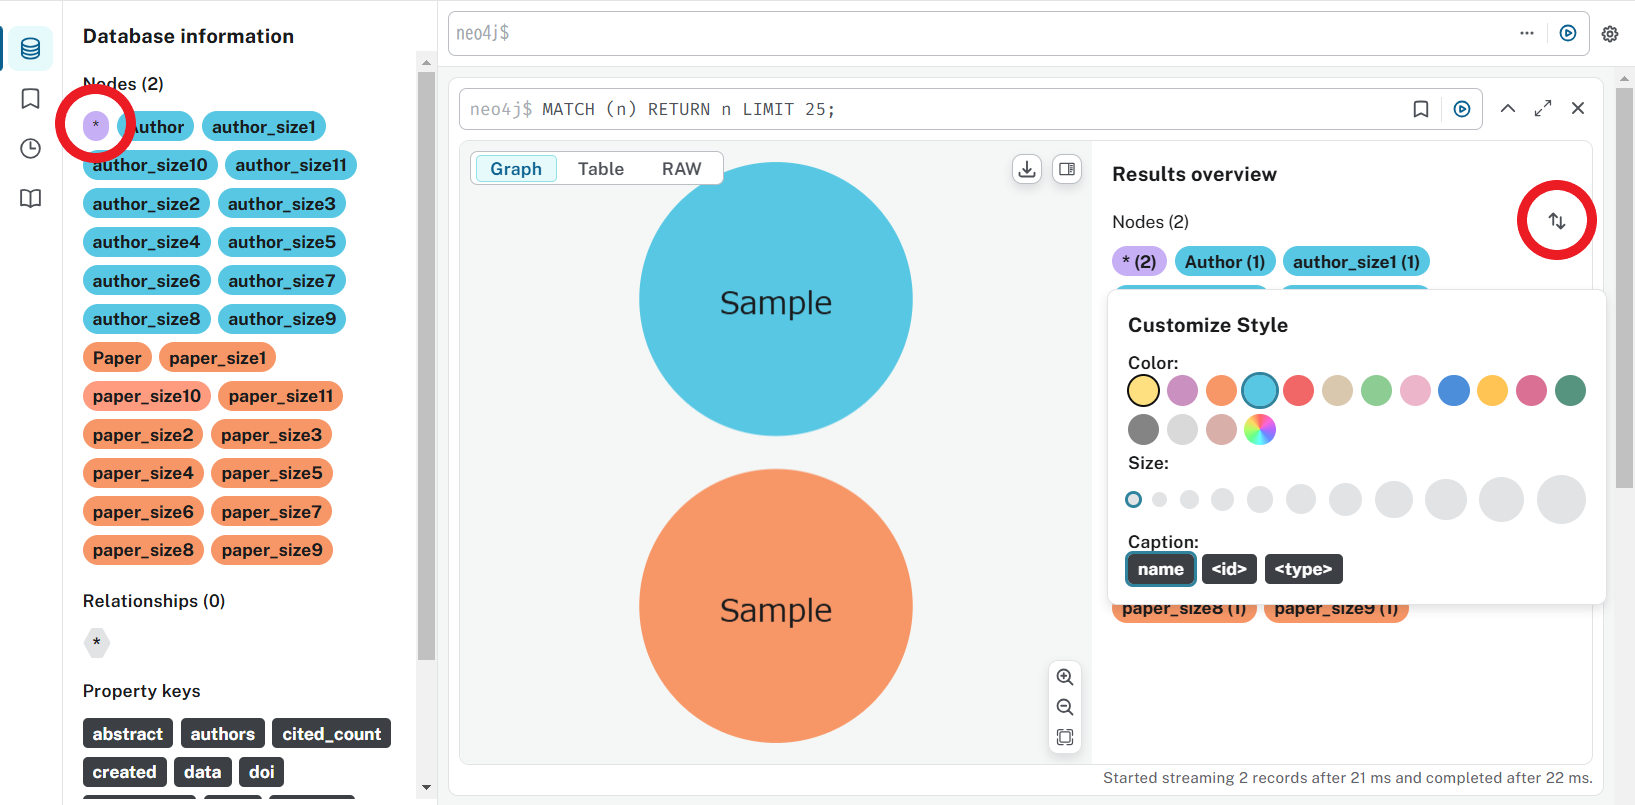

ラベルの優先度（表示順）を設定します．次の画像のように優先度を並べ替えてください．Author ラベルも同様に設定してください．

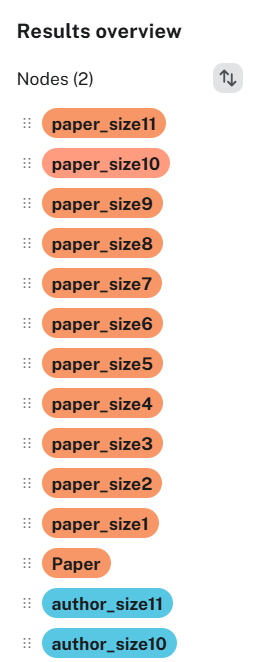

以上で事前準備は完了です．続いてコードの実行に移ります．

# コードの実行

## ライブラリのインストール

In [ ]:
!pip install neo4j
!pip install openai
!pip install pymupdf4llm
!pip install unstructured[pdf]

## ライブラリのインポート

In [ ]:
import os
import re
import time
import json
import requests
import datetime
import itertools
import pymupdf4llm
import numpy as np
from openai import OpenAI
from tokenize import String
from neo4j import GraphDatabase
from unstructured.documents.elements import ListItem
from unstructured.partition.pdf import partition_pdf

## 設定
Neo4jへの接続情報はインスタンスを作成した際にダウンロードしたテキストファイルの情報をコピー＆ペーストしてください．OpenAIのAPIキーの設定も忘れずに．

In [ ]:
# 論文の PDF ファイルのパス
file = "KGRC2024.pdf"

# 検索数（int）
# 大きいほど精度は良くなりますが実行時間が長くなります
search_n = 3

# OpenAI
client = OpenAI()
# LLM モデル
llm_model = "gpt-4o-mini"
# embedding モデル
embedding_model = "text-embedding-3-small"

# Neo4j への接続情報
NEO4J_URI = "URI"
NEO4J_USERNAME = "USERNAME"
NEO4J_PASSWORD = "PASSWORD"
# Neo4j とのコネクション確立
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

## システムの実行

In [ ]:
# 文字列を埋め込み表現に変換する関数
def get_embedding(text: str) -> list[float]:
    result = client.embeddings.create(input=[text], model=embedding_model).data[0].embedding
    return result

# Neo4j で論文ノード検索する関数
def paper_search(vector: list, k: int = 3):
    # 既存のベクトルインデックスの削除
    driver.execute_query("DROP INDEX paper_index IF EXISTS")
    # ベクトルインデックスの作成
    driver.execute_query(
        """
        CREATE VECTOR INDEX paper_index IF NOT EXISTS
        FOR (p:Paper)
        ON p.embedding
        OPTIONS { indexConfig: {`vector.dimensions`: 1536, `vector.similarity_function`: 'cosine'}}
        """
    )
    # 論文ノードの検索
    records = driver.execute_query(
        """
        CALL db.index.vector.queryNodes('paper_index', $k, $vector)
        YIELD node, score
        RETURN node.title as title, node.authors as authors, score
        """,
        k=k,
        vector=vector,
    ).records
    # 検索結果の格納
    messages = []
    for record in records:
        message = {"title": record["title"], "authors": record["authors"], "score": record["score"]}
        messages.append(message)
    return messages

# Neo4j で著者ノード検索する関数
def author_search(vector: list, k: int = 3):
    # 既存のベクトルインデックスの削除
    driver.execute_query("DROP INDEX author_index IF EXISTS")
    # ベクトルインデックスの作成
    driver.execute_query(
        """
        CREATE VECTOR INDEX author_index IF NOT EXISTS
        FOR (a:Author)
        ON a.embedding
        OPTIONS { indexConfig: {`vector.dimensions`: 1536, `vector.similarity_function`: 'cosine'}}
        """
    )
    # 著者ノードの検索
    records = driver.execute_query(
        """
        CALL db.index.vector.queryNodes('author_index', $k, $vector)
        YIELD node, score
        RETURN node.name as name, score
        """,
        k=k,
        vector=vector,
    ).records
    # 検索結果の格納
    messages = []
    for record in records:
        message = {"name": record["name"], "score": record["score"]}
        messages.append(message)
    return messages

# 単語とその出現位置のリストから元のテキストを再構成する関数
def reconstruct_text(inverted_index):
    if inverted_index:
        # 各単語の出現位置をもとにタプルリストを作成
        words_with_positions = [(position, word) for word, positions in inverted_index.items() for position in positions]
        # 出現位置でソート
        words_with_positions.sort()
        # ソートされた単語リストからテキストを結合
        sorted_words = [word for _, word in words_with_positions]
        # 単語をスペースで結合してテキストを生成
        return ' '.join(sorted_words)
    else:
        return str(inverted_index)

# string を date 型に変換する関数
def string_to_date(string: str):
    s_format = '%Y-%m-%d'
    dt = datetime.datetime.strptime(string, s_format)
    return dt.date()

# 論文の引用数に応じてラベルを付与する関数
def citation_label(cited_count):
    # x^4
    if cited_count < 1:
        return "SET b:paper_size1"
    elif cited_count < 16:
        return "SET b:paper_size2"
    elif cited_count < 81:
        return "SET b:paper_size3"
    elif cited_count < 256:
        return "SET b:paper_size4"
    elif cited_count < 625:
        return "SET b:paper_size5"
    elif cited_count < 1296:
        return "SET b:paper_size6"
    elif cited_count < 2401:
        return "SET b:paper_size7"
    elif cited_count < 4096:
        return "SET b:paper_size8"
    elif cited_count < 6561:
        return "SET b:paper_size9"
    elif cited_count < 10000:
        return "SET b:paper_size10"
    elif cited_count >= 10000:
        return "SET b:paper_size11"

# 著者の H 指数と平均引用数に応じてラベルを付与する関数
def h_index_label(h_index, cited, works):
    weight = int(np.sqrt(cited / works))
    value = h_index + weight
    # x^2
    if value < 1:
        return "SET b:author_size1"
    elif value < 4:
        return "SET b:author_size2"
    elif value < 9:
        return "SET b:author_size3"
    elif value < 16:
        return "SET b:author_size4"
    elif value < 25:
        return "SET b:author_size5"
    elif value < 36:
        return "SET b:author_size6"
    elif value < 49:
        return "SET b:author_size7"
    elif value < 64:
        return "SET b:author_size8"
    elif value < 81:
        return "SET b:author_size9"
    elif value < 100:
        return "SET b:author_size10"
    elif value >= 100:
        return "SET b:author_size11"

# コサイン類似度を計算する関数
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))



# -------------------------ノード情報の抽出-------------------------
# pymupdf4llm を使って PDF を Markdown 形式に変換
md_text = pymupdf4llm.to_markdown(file)

# LLM を用いて、Markdown 形式の論文テキストから情報の抽出
completion = client.chat.completions.create(
    model=llm_model,
    messages=[
        {"role": "system",
         "content": """\
         # Instruction 1
         Get the following information from the paper text provided by the user:
         - title
         - authors
         - field
         - created
         - abstract

         # Instruction 2
         Please return the answer as a dictionary.
         ### Example
         {"title" : "ChatGPT", "authors" : "OpenAI", ...}

         # Instruction 3
         Output `created` in year-month-day format. If the month and day are unknown, use "year-01-01".

         # Instruction 4
         Classify the `field` into one of the following:
         - Medicine
         - Social Sciences
         - Engineering
         - Arts and Humanities
         - Computer Science
         - Biochemistry, Genetics and Molecular Biology
         - Agricultural and Biological Sciences
         - Environmental Science
         - Physics and Astronomy
         - Materials Science
         - Business, Management and Accounting
         - Economics, Econometrics and Finance
         - Psychology
         - Health Professions
         - Chemistry
         - Earth and Planetary Sciences
         - Neuroscience
         - Mathematics
         - Immunology and Microbiology
         - Decision Sciences
         - Energy
         - Nursing
         - Pharmacology, Toxicology and Pharmaceutics
         - Dentistry
         - Chemical Engineering
         - Veterinary

         ## Notes
         If no information is found, please mark it as "unknown".\
         """},
        {"role": "user", "content": md_text}
    ],
    temperature=0.0
)

# LLM の出力を json 形式に変換
pattern = '{(.*)}'
result = re.search(pattern, completion.choices[0].message.content, re.S)
node_data = json.loads(result.group())

# 進捗確認用
print("node information OK")



# -------------------------リレーション情報抽出-------------------------
# 参考文献リスト抽出
# 正規表現パターン 1（英語用）
pattern = '(References|REFERENCES|R E F E R E N C E S|Bibliography|NOTES)(.*)-----'
result = re.search(pattern, md_text, re.S)
# 正規表現パターン 2（日本語用）
if result is None:
    pattern = '(#+ |\*\*)(参考文献|参 考 文 献|文献)(.*)-----'
    result = re.search(pattern, md_text, re.S)

if result is not None:
    text = result.group()
# 上記の方法（正規表現）で参考文献リストの取得に失敗した場合は Unstructured を使う
else:
    # partition の設定
    pdf_elements = partition_pdf(
        filename = file,                # ファイルへのパス
        strategy = "hi_res",            # "hi_res" はドキュメントの要素の正確な分類に有効
        extract_images_in_pdf = True,   # "hi_res" を設定するときに "True" にする必要がある
    )
    # 箇条書き項目の抽出
    listItems = [element.text for element in pdf_elements if isinstance(element, ListItem)]
    text = "\n".join(listItems)


# LLM を用いて、参考文献リストから論文のタイトルだけを抽出
# 参考文献リストが長い場合は出力に影響を与えるので分割する
if len(text) > 15000:
    half = len(text) // 2
    text_list = [text[:half], text[half:]]
    reference_list = []
    for texts in text_list:
        completion = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system",
                 "content": """\
                 Extract only the titles of the papers from the given text. Please return the answer in bullet points.
                 ### Example
                 - Learning Crosslingual Word Embeddings without Bilingual Corpora
                 - Semi-Supervised Translation with MMD Networks
                 ...\
                 """},
                {"role": "user", "content": texts}
            ],
            temperature=0.0
        )
        reference_list += [x.lstrip("- ") for x in completion.choices[0].message.content.split("\n")]
else:
    completion = client.chat.completions.create(
        model=llm_model,
        messages=[
            {"role": "system",
             "content": """\
             Extract only the titles of the papers from the given text. Please return the answer in bullet points.
             ### Example
            - Learning Crosslingual Word Embeddings without Bilingual Corpora
            - Semi-Supervised Translation with MMD Networks
            ...\
            """},
            {"role": "user", "content": text}
        ],
        temperature=0.0
    )
    reference_list = [x.lstrip("- ") for x in completion.choices[0].message.content.split("\n")]

# 進捗確認用
print("relation information OK")



# -------------------------Neo4jへの情報登録-------------------------
# 論文ノードの登録
# データベース内をベクトルインデックスを用いて検索
success = False
vector1 = get_embedding(node_data["title"])
search_results = paper_search(vector1, k=search_n)
for result in search_results:
    if result["score"] >= 0.95:
        success = True
        node_data["title"] = result["title"]
        node_data["authors"] = result["authors"]
        break

# OpenAlexAPI を使って検索
if success == False:
    url = "https://api.openalex.org/works"
    params = {
        "search": node_data["title"],
        "per-page": search_n
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for work in data["results"]:
            vector2 = get_embedding(work["title"])
            similarity = cos_sim(vector1, vector2)
            if similarity >= 0.9:
                success = True
                if work["primary_topic"] is None:
                    main = "None"
                    sub = "None"
                else:
                    main = work["primary_topic"]["field"]["display_name"]
                    sub = work["primary_topic"]["subfield"]["display_name"]
                driver.execute_query(
                    """
                    CREATE (b:Paper {title: $title, authors: $authors, field: $field, subfield: $subfield, created: $created, abstract: $abstract, doi: $doi, cited_count: $cited_count, embedding: $embedding})
                    """ + citation_label(work["cited_by_count"]),
                    title = work["title"],
                    authors = ", ".join([author["author"]["display_name"] for author in work["authorships"]]),
                    field = main,
                    subfield = sub,
                    created = string_to_date(work["publication_date"]),
                    abstract = reconstruct_text(work["abstract_inverted_index"]),
                    doi = work["doi"],
                    cited_count = work["cited_by_count"],
                    embedding = vector2
                )
                node_data["title"] = work["title"]
                node_data["authors"] = [author["author"]["display_name"] for author in work["authorships"]]
                break
    else:
        print(f"OpenAlex API Error: {response.status_code}")
        time.sleep(3)

# 失敗した場合は新規作成
if success == False:
    driver.execute_query(
        "CREATE (:Paper {title: $title, authors: $authors, field: $field, created: $created, abstract: $abstract, embedding: $embedding})",
        title = node_data["title"],
        authors = node_data["authors"],
        field = node_data["field"],
        created = string_to_date(node_data["created"]),
        abstract = node_data["abstract"],
        embedding = vector1
    )


# リレーション情報登録
reference_fields = {}
for reference in reference_list:
    # データベース内をベクトルインデックスを用いて検索
    success = False
    vector1 = get_embedding(reference)
    search_results = paper_search(vector1, k=search_n)
    for result in search_results:
        if result["score"] >= 0.95:
            success = True
            records = driver.execute_query(
                """
                MATCH (a:Paper {title: $titleA})
                MATCH (b:Paper {title: $titleB})
                CREATE (a) -[:Refer]-> (b)
                RETURN b.field as field
                """,
                titleA = node_data["title"],
                titleB = result["title"]
            ).records
            for record in records:
                if record["field"] in reference_fields.keys():
                    reference_fields[record["field"]] += 1
                else:
                    reference_fields[record["field"]] = 1
            break

    # OpenAlexAPI を使って検索
    if success == False:
        url = "https://api.openalex.org/works"
        params = {
            "search": reference,
            "per-page": search_n
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            for work in data["results"]:
                if work["title"] is not None:
                    vector2 = get_embedding(work["title"])
                    similarity = cos_sim(vector1, vector2)
                    if similarity >= 0.9:
                        success = True
                        if work["primary_topic"] is None:
                            main = "None"
                            sub = "None"
                        else:
                            main = work["primary_topic"]["field"]["display_name"]
                            sub = work["primary_topic"]["subfield"]["display_name"]
                        driver.execute_query(
                            """
                            MATCH (a:Paper {title: $titleA})
                            CREATE (b:Paper {title: $titleB, authors: $authorsB, field: $field, subfield: $subfield, created: $created, abstract: $abstract, doi: $doi, cited_count: $cited_count, embedding: $embedding})
                            CREATE (a) -[:Refer]-> (b)
                            """ + citation_label(work["cited_by_count"]),
                            titleA = node_data["title"],
                            titleB = work["title"],
                            authorsB = ", ".join([author["author"]["display_name"] for author in work["authorships"]]),
                            field = main,
                            subfield = sub,
                            created = string_to_date(work["publication_date"]),
                            abstract = reconstruct_text(work["abstract_inverted_index"]),
                            doi = work["doi"],
                            cited_count = work["cited_by_count"],
                            embedding = vector2
                        )
                        if main in reference_fields.keys():
                            reference_fields[main] += 1
                        else:
                            reference_fields[main] = 1
                        break
        else:
            print(f"OpenAlex API Error: {response.status_code}")
            time.sleep(3)

# 参考文献の分野に基づいて論文の分野を是正
if sum(reference_fields.values()) >= 5:
    revised_field = max(reference_fields, key=reference_fields.get)
    if node_data["field"] != revised_field:
        driver.execute_query(
            """
            MATCH (a:Paper {title: $title})
            SET a += {field: $field}
            """,
            title = node_data["title"],
            field = revised_field
        )
        node_data["field"] = revised_field

# 進捗確認用
print("Papaer OK")


# 著者ノードの登録
if type(node_data["authors"]) == str:
    authors = node_data["authors"].split(", ")
elif type(node_data["authors"]) == list:
    authors = node_data["authors"]

revised_authors = []
for author in authors:
    # データベース内をベクトルインデックスを用いて検索
    success = False
    vector1 = get_embedding(author)
    search_results = author_search(vector1, k=search_n)
    for result in search_results:
        if result["score"] >= 0.95:
            success = True
            driver.execute_query(
                """
                MATCH (a:Paper {title: $title})
                MATCH (b:Author {name: $name})
                CREATE (b) -[:Write]-> (a)
                """,
                title = node_data["title"],
                name = result["name"]
            )
            revised_authors.append(result["name"])
            break

    # OpenAlexAPI を使って検索
    if success == False:
        url = "https://api.openalex.org/authors"
        params = {
            "search": author,
            "per-page": search_n
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            for work in data["results"]:
                if success == False:
                    for name in work["display_name_alternatives"]:
                        vector2 = get_embedding(name)
                        similarity = cos_sim(vector1, vector2)
                        if similarity >= 0.9:
                            search_results = author_search(vector2, k=search_n)
                            for result in search_results:
                                if result["score"] >= 0.95:
                                    success = True
                                    driver.execute_query(
                                        """
                                        MATCH (a:Paper {title: $title})
                                        MATCH (b:Author {name: $name})
                                        CREATE (b) -[:Write]-> (a)
                                        """,
                                        title = node_data["title"],
                                        name = result["name"]
                                    )
                                    revised_authors.append(result["name"])
                                    break
                            if success == False:
                                success = True
                                driver.execute_query(
                                    """
                                    MATCH (a:Paper {title: $title})
                                    CREATE (b:Author {name: $name, orcid_id: $orcid_id, works: $works, cited_count: $cited, field: $field, h_index: $h_index, embedding: $embedding})
                                    CREATE (b) -[:Write]-> (a)
                                    """ + h_index_label(work["summary_stats"]["h_index"], work["cited_by_count"], work["works_count"]),
                                    title = node_data["title"],
                                    name = name,
                                    orcid_id = work["orcid"],
                                    works = work["works_count"],
                                    cited = work["cited_by_count"],
                                    field = work["x_concepts"][0]["display_name"],
                                    h_index = work["summary_stats"]["h_index"],
                                    embedding = vector2
                                )
                                revised_authors.append(name)
                            break
        else:
            print(f"OpenAlex API Error: {response.status_code}")
            time.sleep(3)

    # 失敗した場合は新規作成
    if success == False:
        driver.execute_query(
            """
            MATCH (a:Paper {title: $title})
            CREATE (:Author {name: $name, field: $field, embedding: $embedding})
            CREATE (b) -[:Write]-> (a)
            """,
            title = node_data["title"],
            name = author,
            field = node_data["field"],
            embedding = vector1
        )
        revised_authors.append(author)

# 著作同士の共著関係を記述
for pair in itertools.combinations(revised_authors, 2):
    driver.execute_query(
        """
        MATCH (a:Author {name: $nameA})
        MATCH (b:Author {name: $nameB})
        CREATE (a) -[:Collaborate]-> (b)
        CREATE (a) <-[:Collaborate]- (b)
        """,
        nameA = pair[0],
        nameB = pair[1]
    )

# 進捗確認用
print("Author OK")



driver.close()
# Neo4j確認用クエリ
print("\nNeo4j query is below")
print("MATCH (n:Paper {title:'" + node_data["title"] + "'}) RETURN n")

出力されたCypherクエリをNeo4jで実行してください．グラフが表示されます．もし，リレーションが表示されない場合は，ノードを右クリックして「Expand」をクリックしてください．

# データベース検索

データベースの検索には Neo4j 独自のクエリ言語である Cypher を使用します．
Cypherでは，ノードは ( )，リレーションは -[ ]->，プロパティは { } で表現します．
以下では検索に使用する代表的な Cypher 構文について説明します．

## RETURN

ノードやリレーション，プロパティを返します.

## MATCH

条件に合うノードやリレーションを検索します．
### 構文
```
MATCH (変数名:ラベル名 {プロパティ名：値})
RETURN 変数名
```
### 具体例
```
MATCH (a:Paper {title："Attention Is All You Need"})
RETURN a, a.name
```
```
MATCH () -[b:Refer]-> ()
RETURN b
```





## WHERE

MATCH したノードやリレーションに対し，さらに条件を絞ります．
### 構文
```
MATCH (変数名:ラベル名 {プロパティ名：値})
WHERE 条件式
RETURN 変数名
```
### 具体例
```
MATCH (n:Paper)
WHERE n.cited_count > 10000
RETURN n
```

